In [19]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time, sleep

from utils import *
from jigsaws_utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

import warnings
warnings.simplefilter('ignore', category=np.ComplexWarning)

seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))

def cross_predict(model, gram_matrix, y, nsplits=5, d_transform=None):
    nsample = len(y)
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    all_preds = []
    all_true = []
    for i, (train_index, test_index) in enumerate(kfolder.split(y, groups=groups)):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        preds = model.predict(gram_test)
        all_preds.append(preds)
        all_true.append(y[test_index])

    return np.concatenate(all_preds), np.concatenate(all_true)

def evaluate_model(model, gram_matrix, y, gestures, nsplits=5, d_transform=None):
    nsample = len(y)
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    ngestures = len(gestures)
    confusion_matrix_cum = np.zeros((ngestures, ngestures))
    count_gesture_presence = np.zeros((ngestures, ngestures))
    accuracy_cum = 0
    for train_index, test_index in kfolder.split(y, groups=groups):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        preds = model.predict(gram_test)
        accuracy_cum += np.mean(y[test_index]==preds)
        cm = confusion_matrix(y[test_index], preds, normalize='true')

        # Handle of missing gestures
        current_gesture_presence = np.ones(cm.shape)
        if cm.shape != (ngestures,ngestures):
            missing_gestures = np.setdiff1d(np.setdiff1d(gestures, preds), y[test_index])

            print(gestures, missing_gestures)
            for g in missing_gestures:
                gi = g2i[g]
                cm = np.insert(cm, gi, 0, axis=0)
                cm = np.insert(cm, gi, 0, axis=1)
                #cm[gi,gi] = 1
                print('AAA')
                print(current_gesture_presence)
                current_gesture_presence = np.insert(current_gesture_presence, gi, 0, axis=0)
                print('BBB')
                print(current_gesture_presence)
                current_gesture_presence = np.insert(current_gesture_presence, gi, 0, axis=1)
                print('CCC')
        confusion_matrix_cum += cm
        count_gesture_presence += current_gesture_presence
        print(current_gesture_presence)
    #if np.any(count_gesture_presence==0):
    #    print('In evaluate_model, zero count:')
    print('End of splits')
    print(count_gesture_presence)
    average_confusion_matrix = confusion_matrix_cum/count_gesture_presence

    accuracy = accuracy_cum / float(nsplits)
    weighted_accuracy = np.mean(np.diag(average_confusion_matrix))

    return accuracy, weighted_accuracy, average_confusion_matrix

def plot_distr(classes, counts, task, alpha=1):
    nclass = len(classes)
    x = range(nclass)
    plt.figure(figsize=(12, 8))
    plt.title('Distribution of gestures for task '+i2task[task])
    plt.bar(x, counts, alpha=alpha, width=0.5)
    plt.xticks(x, classes)
    plt.xlabel('Gesture id')
    plt.ylabel('Number of instances of gesture')
    plt.savefig('data_generated/gesture_distribution_'+i2task[task]+'.png')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Missing file for: task 'Knot_Tying', subject 'B', trial 5
Missing file for: task 'Knot_Tying', subject 'H', trial 1
Missing file for: task 'Knot_Tying', subject 'H', trial 2
Missing file for: task 'Knot_Tying', subject 'I', trial 4


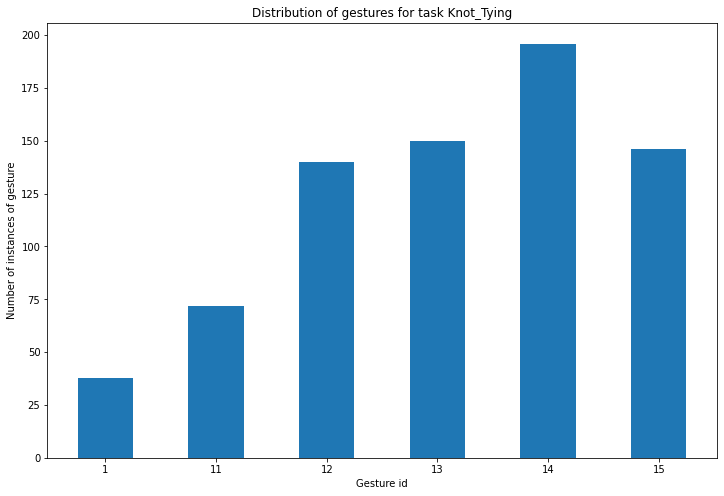

Missing file for: task 'Needle_Passing', subject 'B', trial 5
Missing file for: task 'Needle_Passing', subject 'E', trial 2
Missing file for: task 'Needle_Passing', subject 'F', trial 2
Missing file for: task 'Needle_Passing', subject 'F', trial 5
Missing file for: task 'Needle_Passing', subject 'H', trial 1
Missing file for: task 'Needle_Passing', subject 'H', trial 3
Missing file for: task 'Needle_Passing', subject 'I', trial 1


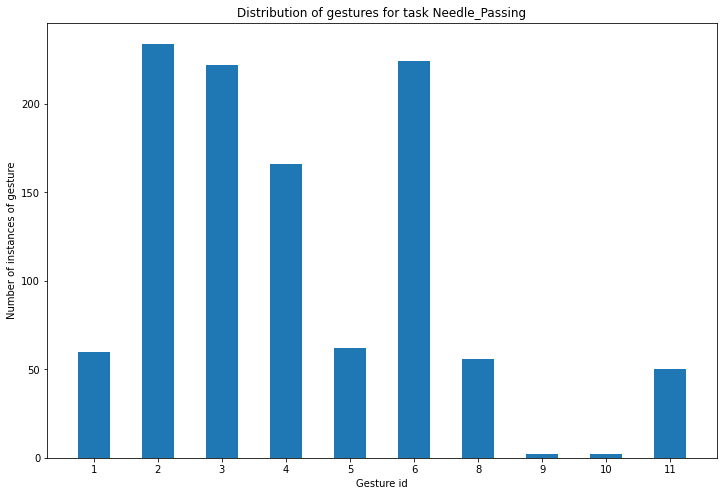

Missing file for: task 'Suturing', subject 'H', trial 2


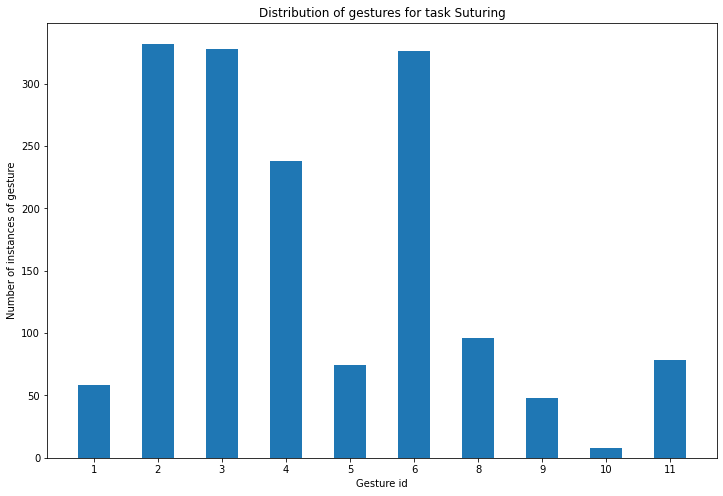

In [20]:
for task in range(3):
    _, y = load_video_data(tasks=task)
    plot_distr(*np.unique(y, return_counts=True), task)
    plt.show()

In [21]:
gestures_for_tasks = [[1,11,12,13,14,15],
                      [1,2,3,4,5,6,8,11],
                      [1,2,3,4,5,6,8,9,11]]

## Evaluation for all tasks and subjects using baseline

In [ ]:
ks = np.arange(1, 8)
gammas = np.logspace(-10, -5, base=2, num=10)
ncomp = 10

In [7]:
task_algo_accuracies = {}
task_algo_weighted_accuracies = {}
task_algo_confusions = {}
subject_gestures = [[] for _ in range(ntask)]
start = time()
for task in range(ntask):
    print(i2task[task]+':')
    task_dir = 'data/JIGSAWS_converted/'+i2task[task]
    stream = os.popen("find %s -name '*.avi' | sed 's:^.*_\([A-Z][0-9]\{3\}\)_[^_]\+$:\\1:'" % task_dir)
    video_meta = list(filter(lambda x: x != '', stream.read().split('\n')))
    task_subjects = np.unique([x[0] for x in video_meta])

    task_gestures = gestures_for_tasks[task]

    for dist, dist_name in [(martin_dist, 'Martin'), (frob_dist, 'Frobenius')]:
        for algo, nhyper in [('KNN', len(ks)), ('SVM', len(gammas))]:
            task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'] = np.zeros(nhyper)
            task_algo_accuracies[f'{task}-{algo}-{dist_name}'] = np.zeros(nhyper)
            task_algo_confusions[f'{task}-{algo}-{dist_name}'] = np.zeros((nhyper, len(task_gestures), len(task_gestures)))
        all_subjects_preds_knn = [[] for _ in ks]
        all_subjects_true_knn = [[] for _ in ks]
        all_subjects_preds_svm = [[] for _ in gammas]
        all_subjects_true_svm = [[] for _ in gammas]
        for subject in task_subjects:
            # Load data and fit the systems
            video_data, y = load_video_data(tasks=task, subjects=subject, gestures=gestures_for_tasks[task])
            nsample = len(y)
            X = []
            mask_videos = np.full(y.shape, True)
            for vi, video in enumerate(video_data):
                if video.duration_frames < ncomp:
                    # Filter too short fragments, frames in annotations do not correspond to videos
                    mask_videos[vi] = False
                    continue
                video.torch = False
                all_frames = video.get_all_frames()

                compression_model = custom_pca(ncomp)
                compression_model.fit(all_frames)
                frames_enc, shape = compression_model.encode(all_frames)
                A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

                X.append((compression_model, A))
            y = y[mask_videos]

            # Compute all distances
            full_gram_matrix = np.zeros((len(X), len(X)))
            for i, mi in enumerate(X):
                for j, mj in enumerate(X):
                    if i > j:
                        full_gram_matrix[i,j] = full_gram_matrix[j,i]
                    else:
                        # Check: negative values appear when computing distance. For the moment round them to zero
                        # while verifying they are all small enough
                        dist_curr = dist(mi, mj)
                        if dist_curr < -1e-13:
                            raise ValueError('Negative values should not appear.')

                        full_gram_matrix[i,j] = dist_curr
            full_gram_matrix[full_gram_matrix < 0] = 0

            # Evaluation using KNN
            for ki, k in enumerate(ks):
                knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
                preds, true = cross_predict(knn, full_gram_matrix, y)
                if ki == 0 and dist_name == 'Martin':
                    print('Sample:', np.mean(np.where(preds==true)[0]))
                all_subjects_preds_knn[ki] = np.append(all_subjects_preds_knn[ki], preds)
                all_subjects_true_knn[ki] = np.append(all_subjects_true_knn[ki], true)

            # Evaluation using SVM
            svm_model = SVC()
            for gammai, gamma in enumerate(gammas):
                preds, true = cross_predict(svm_model, full_gram_matrix, y, d_transform=lambda x: np.exp(-gamma*x))
                print(np.sum(np.where(preds==true)[0]))
                all_subjects_preds_svm[gammai] = np.append(all_subjects_preds_svm[gammai], preds)
                all_subjects_true_svm[gammai] = np.append(all_subjects_true_svm[gammai], true)

            print('\tDone computation for subject '+subject+': '+sec2string(time()-start))

        for algo, all_subjects_preds, all_subjects_true in zip(['KNN', 'SVM'],
                                                              [all_subjects_preds_knn, all_subjects_preds_svm],
                                                              [all_subjects_true_knn, all_subjects_true_svm]):
            task_algo_accuracies[f'{task}-{algo}-{dist_name}'] = [accuracy_score(true, preds) for preds, true in zip(all_subjects_preds, all_subjects_true)]
            task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'] = [balanced_accuracy_score(true, preds) for preds, true in zip(all_subjects_preds, all_subjects_true)]
            task_algo_confusions[f'{task}-{algo}-{dist_name}'] = [confusion_matrix(true, preds, normalize='true') for preds, true in zip(all_subjects_preds, all_subjects_true)]

Knot_Tying:
Missing file for: task 'Knot_Tying', subject 'B', trial 5
Sample: 35.96153846153846
1606
1606
1577
1577
1577
1602
1592
1720
1576
1412
	Done computation for subject B: 0:01:32
Sample: 50.425
3811
3912
3901
3971
4083
4399
4383
4536
4310
3253
	Done computation for subject C: 0:03:50
Sample: 55.83720930232558
4841
4841
4841
4841
4867
4913
5057
5128
5057
4806
	Done computation for subject D: 0:06:16
Sample: 53.05
5006
5006
5072
5108
5354
5354
5446
5524
5329
4809
	Done computation for subject E: 0:08:42
Sample: 54.4
3361
3361
3399
3399
3480
3411
3355
3266
3203
2868
	Done computation for subject F: 0:11:06
Sample: 50.59036144578313
3550
3553
3652
3652
3902
3902
3973
4119
4443
3970
	Done computation for subject G: 0:14:04
Missing file for: task 'Knot_Tying', subject 'H', trial 1
Missing file for: task 'Knot_Tying', subject 'H', trial 2
Sample: 28.45
921
938
938
938
950
1061
1084
1063
951
759
	Done computation for subject H: 0:15:04
Missing file for: task 'Knot_Tying', subject 'I', 

In [8]:
pickle.dump(task_algo_accuracies, open('data_generated/jigsaws_eval_accuracies_baseline.pkl', 'wb'))
pickle.dump(task_algo_weighted_accuracies, open('data_generated/jigsaws_eval_weighted_accuracies_baseline.pkl', 'wb'))
pickle.dump(task_algo_confusions, open('data_generated/jigsaws_eval_confusions_baseline.pkl', 'wb'))

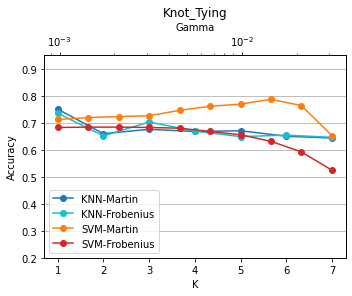

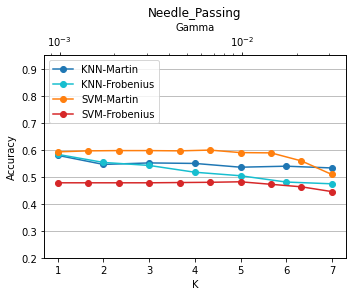

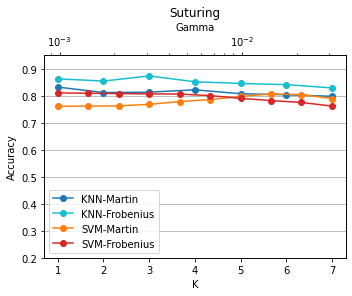

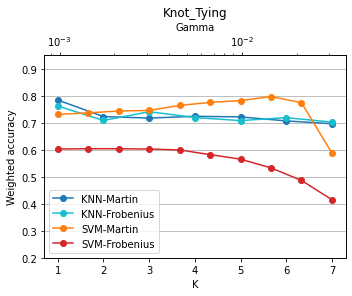

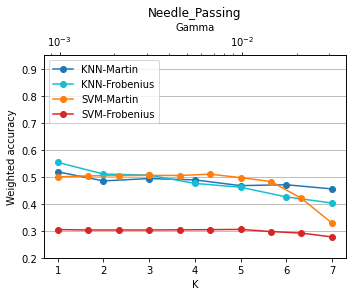

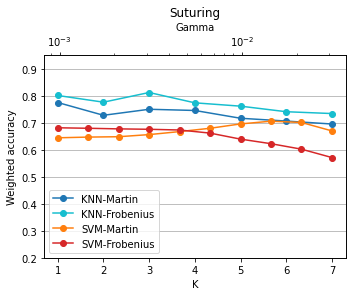

In [14]:
task_algo_accuracies = pickle.load(open('data_generated/jigsaws_eval_accuracies_baseline.pkl', 'rb'))
task_algo_weighted_accuracies = pickle.load(open('data_generated/jigsaws_eval_weighted_accuracies_baseline.pkl', 'rb'))
colors_KNN = ['tab:blue', 'tab:cyan']
colors_SVM = ['tab:orange', 'tab:red']
yrange =(0.2, 0.95)
size=(5,4)

# Accuracy
for task in range(ntask):
    plt.figure(figsize=size)
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.grid(axis='y')
    plt.ylim(yrange)
    algo = 'KNN'
    for j, dist_name in enumerate(['Martin', 'Frobenius']):
        plt.plot(ks, task_algo_accuracies[f'{task}-{algo}-{dist_name}'],
                color=colors_KNN[j], marker='o', label=f'{algo}-{dist_name}')


    ax1 = plt.gca()
    handles, labels = ax1.get_legend_handles_labels()
    ax2 = ax1.twiny()
    ax2.set_xlabel('Gamma')
    ax2.tick_params(axis='x')
    ax2.set_xscale('log')

    algo = 'SVM'
    for j, dist_name in enumerate(['Martin', 'Frobenius']):
        ax2.plot(gammas, task_algo_accuracies[f'{task}-{algo}-{dist_name}'],
                color=colors_SVM[j], marker='o', label=f'{algo}-{dist_name}')
    handles_, labels_ = ax2.get_legend_handles_labels()
    pos = 'upper left' if i2task[task] == 'Needle_Passing' else 'lower left'
    plt.legend(handles+handles_, labels+labels_, loc=pos)
    plt.tight_layout()

    plt.savefig('data_generated/report_figures/evaluation_jigsaws_accuracy_baseline_%s.png' % i2task[task])
    plt.title(i2task[task])
    plt.show()
    
# Weighted accuracy
for task in range(ntask):
    plt.figure(figsize=size)
    plt.xlabel('K')
    plt.ylabel('Weighted accuracy')
    plt.grid(axis='y')
    plt.ylim(yrange)
    algo = 'KNN'
    for j, dist_name in enumerate(['Martin', 'Frobenius']):
        plt.plot(ks, task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'],
                color=colors_KNN[j], marker='o', label=f'{algo}-{dist_name}')

    ax1 = plt.gca()
    handles, labels = ax1.get_legend_handles_labels()
    ax2 = ax1.twiny()
    ax2.set_xlabel('Gamma')
    ax2.tick_params(axis='x')
    ax2.set_xscale('log')

    algo = 'SVM'
    for j, dist_name in enumerate(['Martin', 'Frobenius']):
        ax2.plot(gammas, task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'],
                color=colors_SVM[j], marker='o', label=f'{algo}-{dist_name}')
    handles_, labels_ = ax2.get_legend_handles_labels()
    pos = 'upper left' if i2task[task] == 'Needle_Passing' else 'lower left'
    plt.legend(handles+handles_, labels+labels_, loc=pos)
    plt.tight_layout()
    
    plt.savefig('data_generated/report_figures/evaluation_jigsaws_weighted_accuracy_baseline_%s.png' % i2task[task])
    plt.title(i2task[task])
    plt.show()

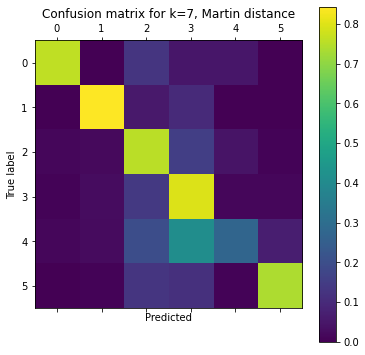

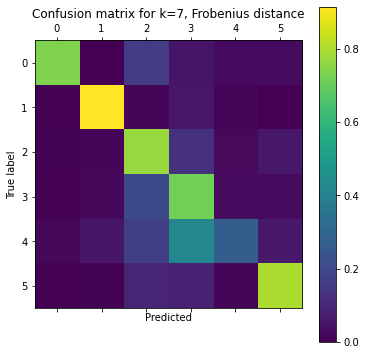

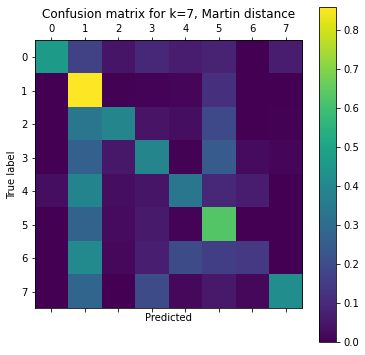

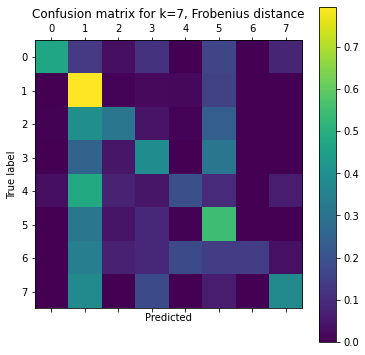

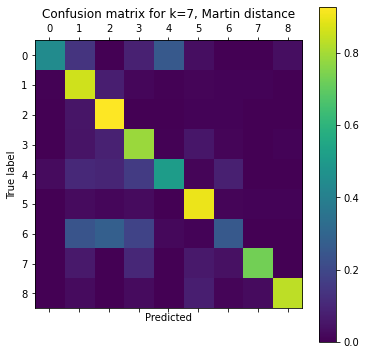

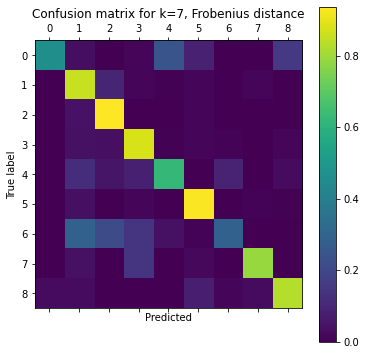

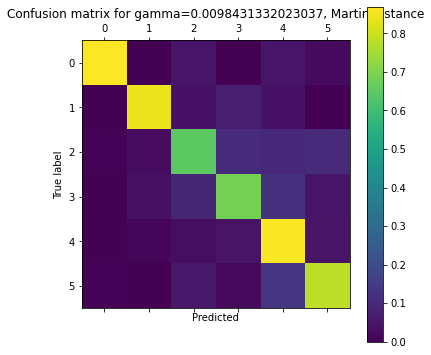

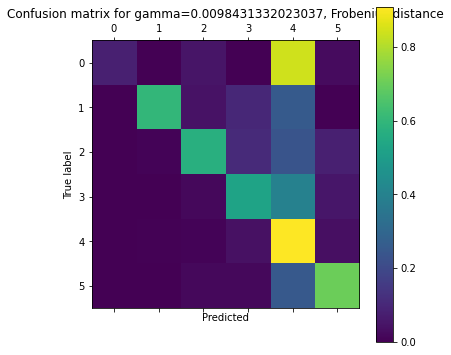

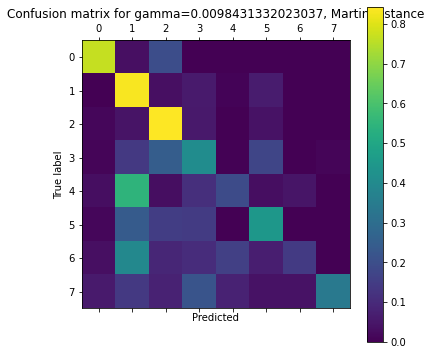

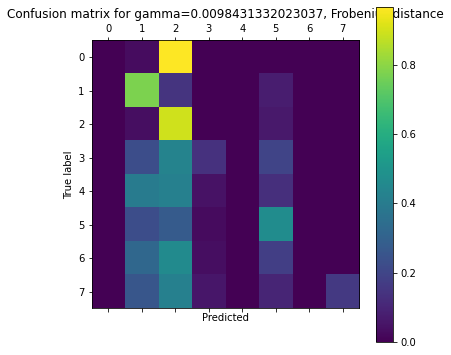

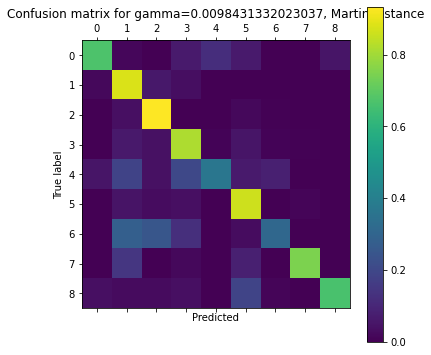

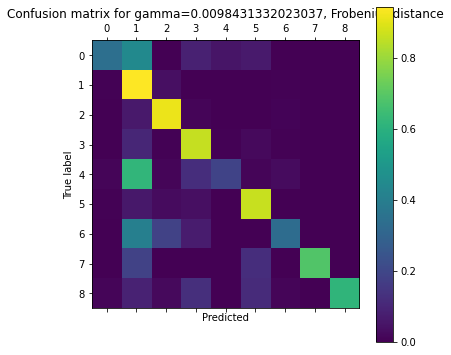

In [14]:
for task in range(ntask):
    for dist_name in ['Martin', 'Frobenius']:
        best_ki = np.argmin(task_algo_accuracies[f'{task}-KNN-{dist_name}'])
        matfig = plt.figure(figsize=(6,6))
        plt.matshow(task_algo_confusions[f'{task}-KNN-{dist_name}'][best_ki], fignum=matfig.number)
        plt.colorbar()
        plt.title(f'Confusion matrix for k={ks[best_ki]}, {dist_name} distance')
        plt.xlabel('Predicted')
        plt.ylabel('True label')
        plt.show()

for task in range(ntask):
    for dist_name in ['Martin', 'Frobenius']:
        best_gammai = np.argmin(task_algo_accuracies[f'{task}-KNN-{dist_name}'])
        matfig = plt.figure(figsize=(6,6))
        plt.matshow(task_algo_confusions[f'{task}-SVM-{dist_name}'][best_gammai], fignum=matfig.number)
        plt.colorbar()
        plt.title(f'Confusion matrix for gamma={gammas[best_gammai]}, {dist_name} distance')
        plt.xlabel('Predicted')
        plt.ylabel('True label')
        plt.show()

ks: 7 7


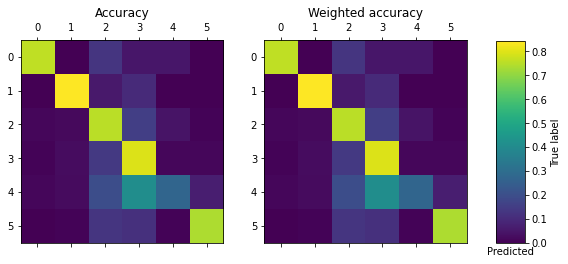

ks: 7 7


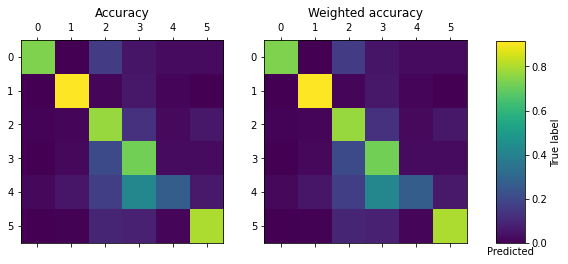

ks: 7 7


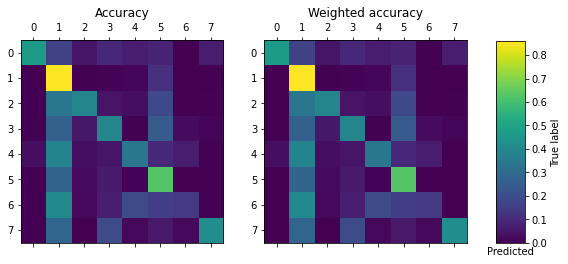

ks: 7 7


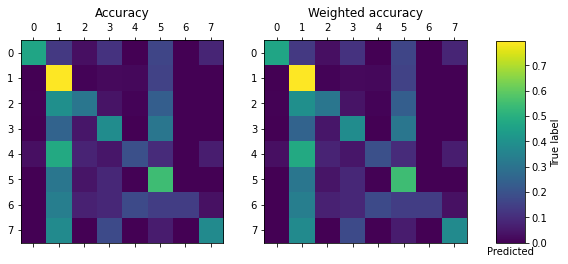

ks: 7 7


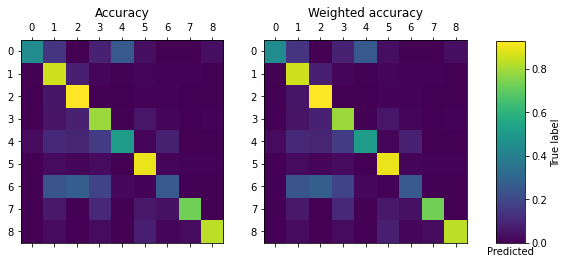

ks: 7 7


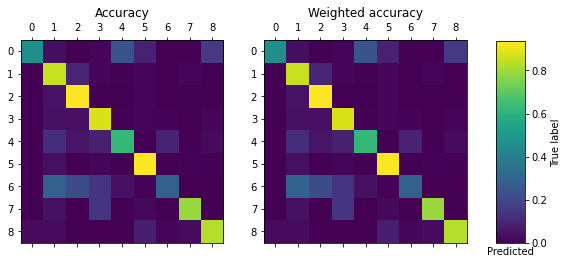

TypeError: colorbar() missing 1 required positional argument: 'mappable'

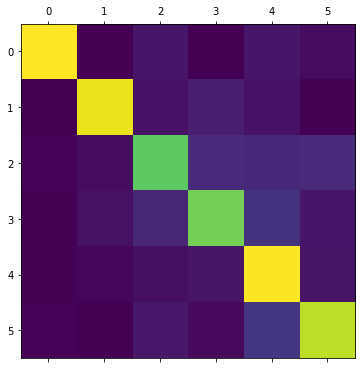

In [16]:
size_double_confusions = (8,4)
for task in range(ntask):
    for dist_name in ['Martin', 'Frobenius']:
        fig, axs = plt.subplots(1, 2, figsize=size_double_confusions)
        best_ki = np.argmin(task_algo_accuracies[f'{task}-KNN-{dist_name}'])
        best_ki_w = np.argmin(task_algo_weighted_accuracies[f'{task}-KNN-{dist_name}'])
        print('ks:', ks[best_ki], ks[best_ki_w])
        conf1 = task_algo_confusions[f'{task}-KNN-{dist_name}'][best_ki]
        conf2 = task_algo_confusions[f'{task}-KNN-{dist_name}'][best_ki_w]
        vmax = np.max(np.concatenate((conf1, conf2)), axis=None)
        axs[0].matshow(conf1, vmin=0, vmax=vmax)
        axs[0].set_title('Accuracy')
        last_im = axs[1].matshow(conf2, vmin=0, vmax=vmax)
        axs[1].set_title('Weighted accuracy')
        cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
        plt.colorbar(last_im, cax=cbar_ax)
        plt.xlabel('Predicted')
        plt.ylabel('True label')
        plt.show()

for task in range(ntask):
    for dist_name in ['Martin', 'Frobenius']:
        best_gammaz = np.argmin(task_algo_accuracies[f'{task}-KNN-{dist_name}'])
        matfig = plt.figure(figsize=(6,6))
        plt.matshow(task_algo_confusions[f'{task}-SVM-{dist_name}'][best_gammai], fignum=matfig.number)
        fig.colorbar()
        plt.title(f'Confusion matrix for gamma={gammas[best_gammai]}, {dist_name} distance')
        plt.xlabel('Predicted')
        plt.ylabel('True label')
        plt.show()

## Evaluation for all tasks and subjects using joint fine tuning

In [3]:
class FramePredictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.predictor = nn.Linear(model.ncomp, model.ncomp)

    def forward(self, x):
        shape = x.shape
        x = self.predictor(x.view(x.shape[0], -1))

        return x.view(shape)

In [3]:
ks = np.arange(1, 8)
gammas = np.logspace(-10, -5, base=2, num=10)
ncomp = 10

In [26]:
num_epoch_tune = 15
lrs = np.logspace(-6, -3, num=8)
verbose = True

task_algo_accuracies = {}
task_algo_weighted_accuracies = {}
task_algo_confusions = {}
start = time()
task = 2
subject = 'B'
dist, dist_name = (martin_dist, 'Martin')

print(i2task[task]+':')
task_dir = 'data/JIGSAWS_converted/'+i2task[task]
task_gestures = gestures_for_tasks[task]

all_subjects_preds_knn = [[] for _ in ks]
all_subjects_true_knn = [[] for _ in ks]
all_subjects_preds_svm = [[] for _ in gammas]
all_subjects_true_svm = [[] for _ in gammas]
fine_tune_losses = []

# Load data and fit the systems
video_data, y = load_video_data(tasks=task, subjects=subject, gestures=gestures_for_tasks[task])
nsample = len(y)
X = []
mask_videos = np.full(y.shape, True)
for vi, video in enumerate(video_data):
    if verbose:
        print(f'Video {vi+1}/{len(video_data)}:', sec2string(time()-start))
    if video.duration_frames < ncomp:
        # Filter too short fragments, frames in annotations do not correspond to videos
        mask_videos[vi] = False
        continue
    video.torch = False
    all_frames = video.get_all_frames()

    pca_model = custom_pca(ncomp)
    pca_model.fit(all_frames)
    frames_enc, shape = pca_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    ############### Fine tuning ###############
    video.torch = True

    # Initialize PCA autoencoder and frame predictor
    np.random.seed(seed)
    torch.manual_seed(seed)
    compression_model = PCAAutoEncoder((1, video.height, video.width), ncomp, pca_model.mean, pca_model.std)
    state_dict = compression_model.state_dict()
    state_dict['to_lower_rep.weight'] = torch.from_numpy(pca_model.C.T)
    state_dict['to_lower_rep.bias'] = torch.zeros_like(state_dict['to_lower_rep.bias'])
    state_dict['from_lower_rep.weight'] = torch.from_numpy(pca_model.C)
    state_dict['from_lower_rep.bias'] = torch.zeros_like(state_dict['from_lower_rep.bias'])
    compression_model.load_state_dict(state_dict)
    compression_model = compression_model.to(device)

    model_ds = FramePredictor(compression_model)
    state_dict = model_ds.state_dict()
    state_dict['predictor.weight'] = torch.from_numpy(A.T)
    state_dict['predictor.bias'] = torch.zeros_like(state_dict['predictor.bias'])
    model_ds.load_state_dict(state_dict)
    model_ds = model_ds.to(device)

    # Compute original loss
    all_frames_pred = []
    for frames in video:
        frames = frames.to(device)
        enc = compression_model.encode(frames)
        all_frames_pred.append(compression_model.decode(model_ds(enc)))
    all_frames_pred = torch.cat(all_frames_pred, 0)
    all_frames_pred = all_frames_pred[:-1]
    original_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

    # Fine tune
    np.random.seed(seed)
    torch.manual_seed(seed)
    iteration_per_epoch = np.ceil(video.duration_frames/video.batch_size)
    optimizer = Adam(list(compression_model.parameters())+list(model_ds.parameters()), lr=5e-7)
    losses = []
    losses.append(original_loss)
    for epoch in range(num_epoch_tune):
        epoch_loss = 0
        for frames in video:
            frames = frames.to(device)
            frames_next_gt = frames[1:]
            frames_enc = compression_model.encode(frames[:-1])
            frames_next = compression_model.decode(model_ds(frames_enc))
            frames_next = frames_next

            loss = crit(frames_next, frames_next_gt)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(epoch_loss/iteration_per_epoch)
    #print(losses)

    # Compute resulting loss
    all_frames_pred = []
    for frames in video:
        frames = frames.to(device)
        enc = compression_model.encode(frames)
        all_frames_pred.append(compression_model.decode(model_ds(enc)))
    all_frames_pred = torch.cat(all_frames_pred, 0)
    all_frames_pred = all_frames_pred[:-1]
    resulting_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])
    fine_tune_losses.append([original_loss, resulting_loss])

    if verbose:
        print(f'Loss: {original_loss} -> {resulting_loss}')

    ############ End of fine tuning ############

    X.append((compression_model, A))
y = y[mask_videos]

# Compute all distances
full_gram_matrix = np.zeros((len(X), len(X)))
for i, mi in enumerate(X):
    for j, mj in enumerate(X):
        if i > j:
            full_gram_matrix[i,j] = full_gram_matrix[j,i]
        else:
            # Check: negative values appear when computing distance. For the moment round them to zero
            # while verifying they are all small enough
            dist_curr = dist(mi, mj, C_key='from_lower_rep.weight')
            if dist_curr < -1e-13:
                raise ValueError('Negative values should not appear.')

            full_gram_matrix[i,j] = dist_curr
full_gram_matrix[full_gram_matrix < 0] = 0

# Evaluation using KNN
for ki, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
    preds, true = cross_predict(knn, full_gram_matrix, y)
    all_subjects_preds_knn[ki] = np.append(all_subjects_preds_knn[ki], preds)
    all_subjects_true_knn[ki] = np.append(all_subjects_true_knn[ki], true)

# Evaluation using SVM
svm_model = SVC()
for gammai, gamma in enumerate(gammas):
    preds, true = cross_predict(svm_model, full_gram_matrix, y, d_transform=lambda x: np.exp(-gamma*x))
    all_subjects_preds_svm[gammai] = np.append(all_subjects_preds_svm[gammai], preds)
    all_subjects_true_svm[gammai] = np.append(all_subjects_true_svm[gammai], true)

print('\tDone computation for subject '+subject+': '+sec2string(time()-start))

fine_tune_losses = np.array(fine_tune_losses)
for algo, all_subjects_preds, all_subjects_true in zip(['KNN', 'SVM'],
                                                  [all_subjects_preds_knn, all_subjects_preds_svm],
                                                  [all_subjects_true_knn, all_subjects_true_svm]):
    task_algo_accuracies[f'{task}-{algo}-{dist_name}'] = [accuracy_score(true, preds) for preds, true in zip(all_subjects_preds, all_subjects_true)]
    task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'] = [balanced_accuracy_score(true, preds) for preds, true in zip(all_subjects_preds, all_subjects_true)]
    task_algo_confusions[f'{task}-{algo}-{dist_name}'] = [confusion_matrix(true, preds, normalize='true') for preds, true in zip(all_subjects_preds, all_subjects_true)]

Suturing:
Video 1/204: 1.08
Loss: 3.3535287380218506 -> 3.354112386703491
Video 2/204: 42.93
Loss: 2.7849104404449463 -> 2.7857043743133545
Video 3/204: 0:01:25
Loss: 5.825448513031006 -> 5.824841499328613
Video 4/204: 0:02:10
Loss: 4.926774024963379 -> 4.926419258117676
Video 5/204: 0:02:54
Loss: 9.199853897094727 -> 9.198943138122559
Video 6/204: 0:03:59
Loss: 7.900753498077393 -> 7.900019645690918
Video 7/204: 0:05:04
Loss: 7.725320816040039 -> 7.7274370193481445
Video 8/204: 0:05:25
Loss: 6.48035192489624 -> 6.482758522033691
Video 9/204: 0:05:46
Loss: 7.41216516494751 -> 7.411697864532471
Video 10/204: 0:07:11
Loss: 6.269585132598877 -> 6.2690863609313965
Video 11/204: 0:08:35
Loss: 6.512343883514404 -> 6.512035369873047
Video 12/204: 0:09:17
Loss: 5.301436424255371 -> 5.301323413848877
Video 13/204: 0:09:59
Loss: 4.899430274963379 -> 4.897495269775391
Video 14/204: 0:10:08
Loss: 4.345947742462158 -> 4.342109203338623
Video 15/204: 0:10:17
Loss: 7.082997798919678 -> 7.083027362823

In [27]:
pickle.dump(fine_tune_losses, open('data_generated/jigsaws_eval_fine_tune_losses_joint.pkl', 'wb'))
pickle.dump(task_algo_accuracies, open('data_generated/jigsaws_eval_accuracies_joint.pkl', 'wb'))
pickle.dump(task_algo_weighted_accuracies, open('data_generated/jigsaws_eval_weighted_accuracies_joint.pkl', 'wb'))
pickle.dump(task_algo_confusions, open('data_generated/jigsaws_eval_confusions_joint.pkl', 'wb'))

In [27]:
task_algo_accuracies_baseline = {}
task_algo_weighted_accuracies_baseline = {}
task_algo_confusions_baseline = {}
start = time()
task = 2
subject = 'B'
dist, dist_name = (martin_dist, 'Martin')

print(i2task[task]+':')
task_dir = 'data/JIGSAWS_converted/'+i2task[task]
task_gestures = gestures_for_tasks[task]

all_subjects_preds_knn = [[] for _ in ks]
all_subjects_true_knn = [[] for _ in ks]
all_subjects_preds_svm = [[] for _ in gammas]
all_subjects_true_svm = [[] for _ in gammas]

# Load data and fit the systems
video_data, y = load_video_data(tasks=task, subjects=subject, gestures=gestures_for_tasks[task])
nsample = len(y)
X = []
mask_videos = np.full(y.shape, True)
for vi, video in enumerate(video_data):
    if video.duration_frames < ncomp:
        # Filter too short fragments, frames in annotations do not correspond to videos
        mask_videos[vi] = False
        continue
    video.torch = False
    all_frames = video.get_all_frames()

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    X.append((compression_model, A))
y = y[mask_videos]

# Compute all distances
full_gram_matrix = np.zeros((len(X), len(X)))
for i, mi in enumerate(X):
    for j, mj in enumerate(X):
        if i > j:
            full_gram_matrix[i,j] = full_gram_matrix[j,i]
        else:
            # Check: negative values appear when computing distance. For the moment round them to zero
            # while verifying they are all small enough
            dist_curr = dist(mi, mj)
            if dist_curr < -1e-13:
                raise ValueError('Negative values should not appear.')

            full_gram_matrix[i,j] = dist_curr
full_gram_matrix[full_gram_matrix < 0] = 0

# Evaluation using KNN
for ki, k in enumerate(ks):
    knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
    preds, true = cross_predict(knn, full_gram_matrix, y)
    all_subjects_preds_knn[ki] = np.append(all_subjects_preds_knn[ki], preds)
    all_subjects_true_knn[ki] = np.append(all_subjects_true_knn[ki], true)

# Evaluation using SVM
svm_model = SVC()
for gammai, gamma in enumerate(gammas):
    preds, true = cross_predict(svm_model, full_gram_matrix, y, d_transform=lambda x: np.exp(-gamma*x))
    all_subjects_preds_svm[gammai] = np.append(all_subjects_preds_svm[gammai], preds)
    all_subjects_true_svm[gammai] = np.append(all_subjects_true_svm[gammai], true)

print(subject)
print(f'\tDone computation for subject {subject}:', sec2string(time()-start))

for algo, all_subjects_preds, all_subjects_true in zip(['KNN', 'SVM'],
                                                  [all_subjects_preds_knn, all_subjects_preds_svm],
                                                  [all_subjects_true_knn, all_subjects_true_svm]):
    task_algo_accuracies_baseline[f'{task}-{algo}-{dist_name}'] = [accuracy_score(true, preds) for preds, true in zip(all_subjects_preds, all_subjects_true)]
    task_algo_weighted_accuracies_baseline[f'{task}-{algo}-{dist_name}'] = [balanced_accuracy_score(true, preds) for preds, true in zip(all_subjects_preds, all_subjects_true)]
    task_algo_confusions_baseline[f'{task}-{algo}-{dist_name}'] = [confusion_matrix(true, preds, normalize='true') for preds, true in zip(all_subjects_preds, all_subjects_true)]

Suturing:
B
	Done computation for subject B: 0:07:42


In [30]:
pickle.dump(task_algo_accuracies_baseline, open('data_generated/jigsaws_eval_accuracies_baseline_Suturing_B.pkl', 'wb'))
pickle.dump(task_algo_weighted_accuracies_baseline, open('data_generated/jigsaws_eval_weighted_accuracies_baseline_Suturing_B.pkl', 'wb'))
pickle.dump(task_algo_confusions_baseline, open('data_generated/jigsaws_eval_confusions_baseline_Suturing_B.pkl', 'wb'))

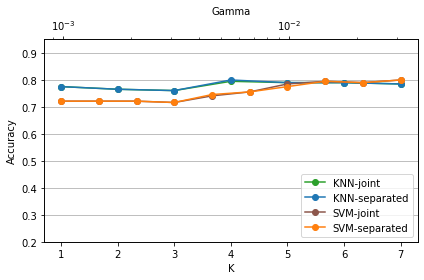

In [18]:
task_algo_accuracies_baseline = pickle.load(open('data_generated/jigsaws_eval_accuracies_baseline_Suturing_B.pkl', 'rb'))
task_algo_weighted_accuracies_baseline = pickle.load(open('data_generated/jigsaws_eval_weighted_accuracies_baseline_Suturing_B.pkl', 'rb'))
task_algo_confusions_baseline = pickle.load(open('data_generated/jigsaws_eval_confusions_baseline_Suturing_B.pkl', 'rb'))
task_algo_accuracies = pickle.load(open('data_generated/jigsaws_eval_accuracies_joint.pkl', 'rb'))
task_algo_weighted_accuracies = pickle.load(open('data_generated/jigsaws_eval_weighted_accuracies_joint.pkl', 'rb'))
task_algo_confusions = pickle.load(open('data_generated/jigsaws_eval_confusions_joint.pkl', 'rb'))
fine_tune_losses = pickle.load(open('data_generated/jigsaws_eval_fine_tune_losses_joint.pkl', 'rb'))

colors_separated = ['tab:blue', 'tab:orange']
colors_joint = ['tab:green', 'tab:brown']
yrange =(0.2, 0.95)
size=(5,4)
dist_name = 'Martin'
task = 2

# Accuracy
plt.figure(figsize=(6, 4))
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.ylim(yrange)
algo = 'KNN'
plt.plot(ks, task_algo_accuracies[f'{task}-{algo}-{dist_name}'], label=f'{algo}-joint', marker='o', color=colors_joint[0])
plt.plot(ks, task_algo_accuracies_baseline[f'{task}-{algo}-{dist_name}'], label=f'{algo}-separated', marker='o', color=colors_separated[0])

ax1 = plt.gca()
handles, labels = ax1.get_legend_handles_labels()
ax2 = ax1.twiny()
ax2.set_xlabel('Gamma')
ax2.tick_params(axis='x')
ax2.set_xscale('log')
algo = 'SVM'
ax2.plot(gammas, task_algo_accuracies[f'{task}-{algo}-{dist_name}'],
        marker='o', label=f'{algo}-joint', color=colors_joint[1])
ax2.plot(gammas, task_algo_accuracies_baseline[f'{task}-{algo}-{dist_name}'],
         marker='o', label=f'{algo}-separated', color=colors_separated[1])
handles_, labels_ = ax2.get_legend_handles_labels()
plt.legend(handles+handles_, labels+labels_)
plt.tight_layout()

plt.savefig('data_generated/report_figures/evaluation_jigsaws_accuracy_joint_vs_separated.png')
plt.legend(handles+handles_, labels+labels_, loc='lower right')
plt.show()

# Weighted accuracy
#plt.figure(figsize=(12,8))
#plt.xlabel('K')
#plt.ylabel('Weighted accuracy')
#plt.grid(axis='y')
##plt.ylim(yrange)
#algo = 'KNN'
#plt.plot(ks, task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'], label=f'{algo}-joint', marker='o')
#plt.plot(ks, task_algo_weighted_accuracies_baseline[f'{task}-{algo}-{dist_name}'], label=f'{task}-sequential', marker='o')
#
#ax1 = plt.gca()
#ax2 = ax1.twiny()
#ax2.set_xlabel('Gamma')
#ax2.tick_params(axis='x')
#ax2.set_xscale('log')

### Misc measures

In [5]:
fine_tune_gains = fine_tune_losses[:,0] - fine_tune_losses[:,1]
np.mean(fine_tune_gains)

-1.0457036e-05

In [39]:
# Average gesture length
x, y = load_video_data(verbose=False)
x = [v.duration for v in x]
for g in np.unique(y):
    xg = np.array(list(zip(x, y)))
    xg = xg[xg[:,1]==g][:,0]
    print(gi2descr[g], ':', np.mean(xg),'sec')

Reaching for needle with right hand : 3.0303418803418802 sec
Positioning needle : 6.202002355712603 sec
Pushing needle through tissue : 6.634060606060606 sec
Transferring needle from left to right : 4.062706270627063 sec
Moving to center with needle in grip : 4.044117647058823 sec
Pulling suture with left hand : 4.7703030303030305 sec
Orienting needle : 6.836403508771929 sec
Using right hand to help tighten suture : 3.233333333333334 sec
Loosening more suture : 10.893333333333334 sec
Dropping suture at end and moving to end points : 5.304333333333333 sec
Reaching for needle with left hand : 6.205238095238095 sec
Making C loop around right hand : 3.417777777777777 sec
Reaching for suture with right hand : 4.305442176870748 sec
Pulling suture with both hands : 8.100913242009133 sec


In [31]:
for task in range(3):
    x,y = load_video_data(tasks=task, verbose=False)
    gests, counts = np.unique(y, return_counts=True)
    gis = np.argsort(counts)[:3]
    print(np.mean(counts))
    
    print('Gestures with lowest appartion:')
    for gi in gis:
        print(f'\tGesture {gests[gi]}: {counts[gi]} ({counts[gi]/np.sum(counts)})')

123.66666666666667
Gestures with lowest appartion:
	Gesture 1: 38 (0.05121293800539083)
	Gesture 11: 72 (0.09703504043126684)
	Gesture 12: 140 (0.18867924528301888)
107.8
Gestures with lowest appartion:
	Gesture 9: 2 (0.0018552875695732839)
	Gesture 10: 2 (0.0018552875695732839)
	Gesture 11: 50 (0.04638218923933209)
158.6
Gestures with lowest appartion:
	Gesture 10: 8 (0.005044136191677175)
	Gesture 9: 48 (0.03026481715006305)
	Gesture 1: 58 (0.03656998738965952)
